# Visualization of Loss Landscapes

This notebook explores the loss landscape of neural networks by training multiple networks initialized with different random weights on the same dataset. We'll visualize how different initializations lead to different trajectories through the loss landscape, but often converge to similar loss values.

The experiment involves:

- Creating a simple synthetic dataset
- Initializing multiple neural networks with different random seeds
- Training each network with identical hyperparameters and optimizer settings
- Tracking the loss trajectory for each network
- Visualizing the loss landscapes in 2D using PCA projection of weight space


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Create Synthetic Dataset

We'll use a simple 2D moons dataset for binary classification. This provides a non-linear decision boundary that requires a neural network to learn.


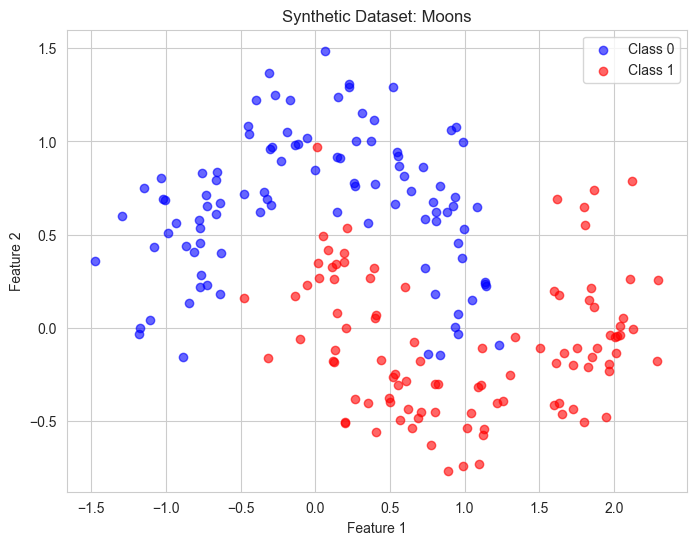

In [2]:
# Generate synthetic dataset
np.random.seed(42)
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).unsqueeze(1)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)  # Fixed order

# Visualize the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', label='Class 0', alpha=0.6)
plt.scatter(X[y==1, 0], X[y==1, 1], c='red', label='Class 1', alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Synthetic Dataset: Moons')
plt.legend()
plt.show()


## 2. Define Neural Network Architecture

We'll use a simple feedforward neural network with two hidden layers. The architecture is kept simple to make the loss landscape visualization more interpretable.


In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
    
    def get_weights_flat(self):
        """Flatten all weights into a single vector"""
        return torch.cat([p.data.flatten() for p in self.parameters()])

# Test the model
test_model = SimpleNN()
print(f"Model architecture:\n{test_model}")
print(f"\nTotal parameters: {sum(p.numel() for p in test_model.parameters())}")


Model architecture:
SimpleNN(
  (fc1): Linear(in_features=2, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 65


## 3. Training Function

Define a training function that will be used consistently across all random initializations. We'll track the loss at each epoch and the weight vectors for visualization.


In [4]:
def train_network(model, dataloader, epochs=100, lr=0.1):
    """Train a network and return loss history and weight trajectory"""
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    loss_history = []
    weight_trajectory = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)
        
        # Store weight snapshot every 5 epochs
        if epoch % 5 == 0:
            weight_trajectory.append(model.get_weights_flat().numpy())
    
    return loss_history, weight_trajectory


## 4. Train Multiple Networks with Different Initializations

Now we'll train multiple networks, each with a different random initialization but identical training procedure. This allows us to explore how initialization affects the optimization trajectory.


In [5]:
# Training parameters
num_networks = 10
epochs = 100
learning_rate = 0.1

# Store results
all_loss_histories = []
all_weight_trajectories = []

print("Training networks with different random initializations...\n")

for i in range(num_networks):
    # Set seed for reproducibility
    torch.manual_seed(i * 100)
    
    # Initialize new network
    model = SimpleNN()
    
    # Train the network
    loss_history, weight_trajectory = train_network(model, dataloader, epochs, learning_rate)
    
    all_loss_histories.append(loss_history)
    all_weight_trajectories.append(weight_trajectory)
    
    print(f"Network {i+1}/{num_networks} - Final Loss: {loss_history[-1]:.4f}")

print("\nTraining complete!")


Training networks with different random initializations...

Network 1/10 - Final Loss: 0.2770
Network 2/10 - Final Loss: 0.3281
Network 3/10 - Final Loss: 0.2321
Network 4/10 - Final Loss: 0.3104
Network 5/10 - Final Loss: 0.2887
Network 6/10 - Final Loss: 0.2711
Network 7/10 - Final Loss: 0.2245
Network 8/10 - Final Loss: 0.2717
Network 9/10 - Final Loss: 0.1828
Network 10/10 - Final Loss: 0.3260

Training complete!


## 5. Visualize Loss Trajectories

First, let's visualize how the loss evolves over training for each network. Despite different initializations, we expect convergence to similar loss values.


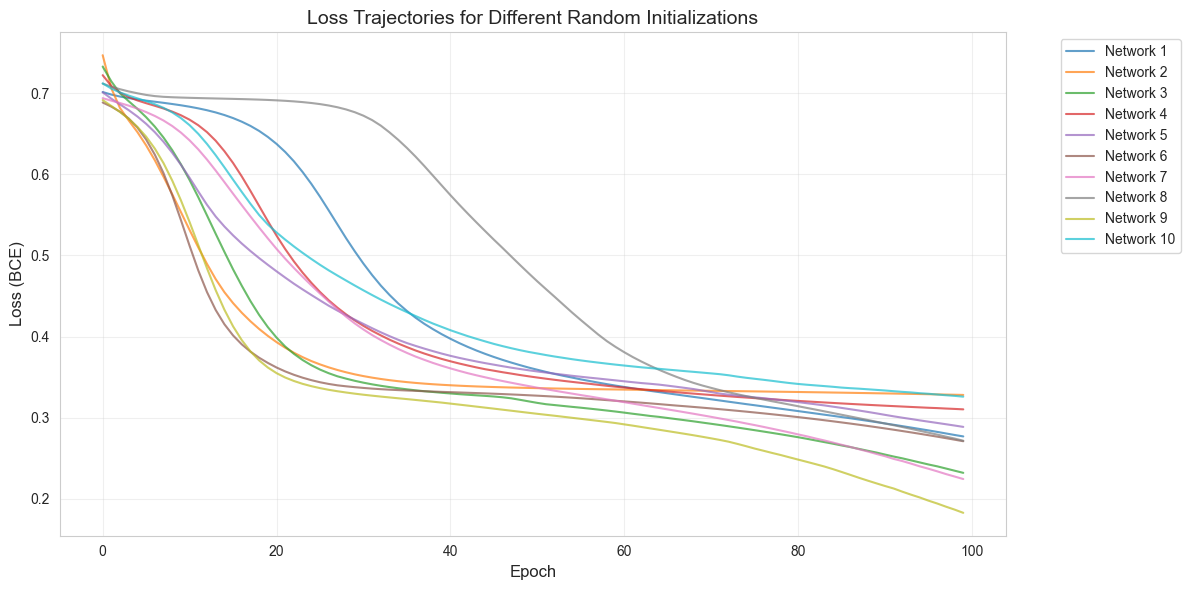


Final Loss Statistics:
Mean: 0.2712
Std:  0.0443
Min:  0.1828
Max:  0.3281


In [6]:
plt.figure(figsize=(12, 6))

for i, loss_history in enumerate(all_loss_histories):
    plt.plot(loss_history, alpha=0.7, label=f'Network {i+1}')

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (BCE)', fontsize=12)
plt.title('Loss Trajectories for Different Random Initializations', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
final_losses = [history[-1] for history in all_loss_histories]
print(f"\nFinal Loss Statistics:")
print(f"Mean: {np.mean(final_losses):.4f}")
print(f"Std:  {np.std(final_losses):.4f}")
print(f"Min:  {np.min(final_losses):.4f}")
print(f"Max:  {np.max(final_losses):.4f}")


## 6. Visualize Weight Space Trajectories with PCA

To visualize the high-dimensional weight space, we'll use PCA to project the weight trajectories into 2D. This shows how different initializations lead to different paths through weight space.


In [7]:
# Flatten all weight trajectories into a single array for PCA
all_weights = []
trajectory_indices = []

for i, trajectory in enumerate(all_weight_trajectories):
    all_weights.extend(trajectory)
    trajectory_indices.extend([i] * len(trajectory))

all_weights = np.array(all_weights)
trajectory_indices = np.array(trajectory_indices)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
weights_2d = pca.fit_transform(all_weights)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")


PCA explained variance ratio: [0.24063638 0.16958411]
Total variance explained: 41.02%


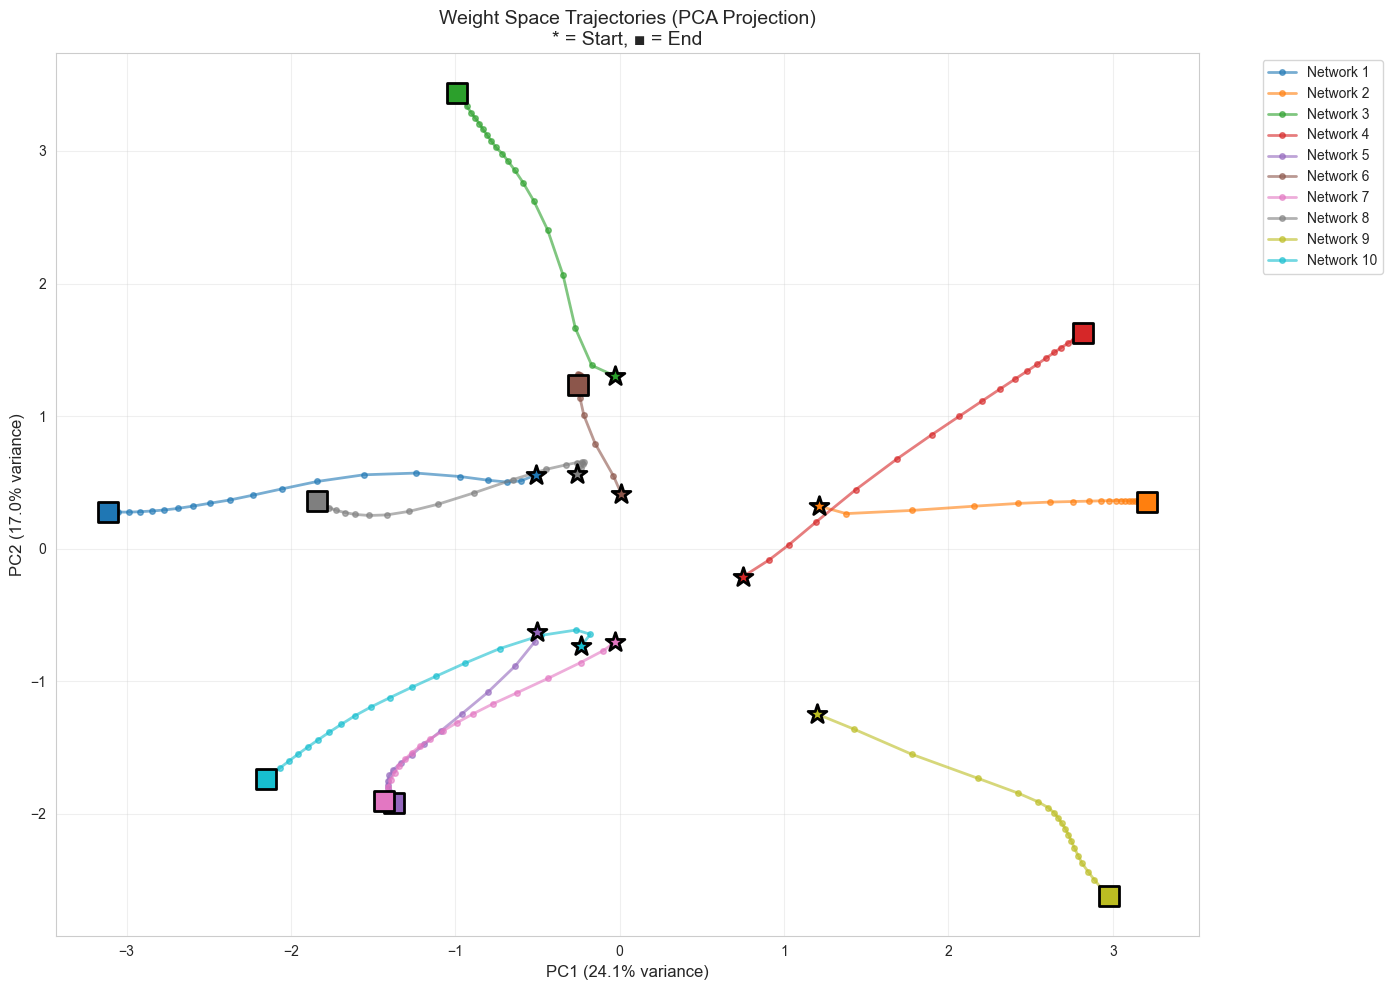

In [8]:
# Visualize trajectories in 2D PCA space
plt.figure(figsize=(14, 10))

colors = plt.cm.tab10(np.linspace(0, 1, num_networks))

for i in range(num_networks):
    # Get indices for this trajectory
    mask = trajectory_indices == i
    traj_2d = weights_2d[mask]
    
    # Plot trajectory
    plt.plot(traj_2d[:, 0], traj_2d[:, 1], 'o-', color=colors[i], 
             alpha=0.6, linewidth=2, markersize=4, label=f'Network {i+1}')
    
    # Mark start and end points
    plt.scatter(traj_2d[0, 0], traj_2d[0, 1], color=colors[i], 
                s=200, marker='*', edgecolors='black', linewidths=2, zorder=5)
    plt.scatter(traj_2d[-1, 0], traj_2d[-1, 1], color=colors[i], 
                s=200, marker='s', edgecolors='black', linewidths=2, zorder=5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Weight Space Trajectories (PCA Projection)\n* = Start, ■ = End', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Create Loss Landscape Heatmap

Finally, we'll create a 2D loss landscape by evaluating the loss at a grid of points in the PCA-projected weight space. This gives us a visual representation of the loss surface.


In [9]:
def evaluate_loss_at_weights(weight_vector, X_tensor, y_tensor):
    """Evaluate loss for a given weight vector"""
    model = SimpleNN()
    
    # Reconstruct model weights from flat vector
    idx = 0
    for param in model.parameters():
        param_length = param.numel()
        param.data = torch.FloatTensor(weight_vector[idx:idx+param_length]).reshape(param.shape)
        idx += param_length
    
    # Evaluate loss
    criterion = nn.BCELoss()
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
    
    return loss.item()

# Create a grid in PCA space
resolution = 30
x_min, x_max = weights_2d[:, 0].min() - 1, weights_2d[:, 0].max() + 1
y_min, y_max = weights_2d[:, 1].min() - 1, weights_2d[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                     np.linspace(y_min, y_max, resolution))

# Evaluate loss at each grid point
print("Computing loss landscape (this may take a moment)...")
loss_landscape = np.zeros_like(xx)

for i in range(resolution):
    for j in range(resolution):
        # Project 2D point back to high-dimensional weight space
        pca_coords = np.array([xx[i, j], yy[i, j]])
        weight_vector = pca.inverse_transform(pca_coords)
        
        # Evaluate loss
        loss_landscape[i, j] = evaluate_loss_at_weights(weight_vector, X_tensor, y_tensor)
    
    if (i + 1) % 5 == 0:
        print(f"Progress: {(i+1)/resolution*100:.0f}%")

print("Loss landscape computation complete!")


Computing loss landscape (this may take a moment)...
Progress: 17%
Progress: 33%
Progress: 50%
Progress: 67%
Progress: 83%
Progress: 100%
Loss landscape computation complete!


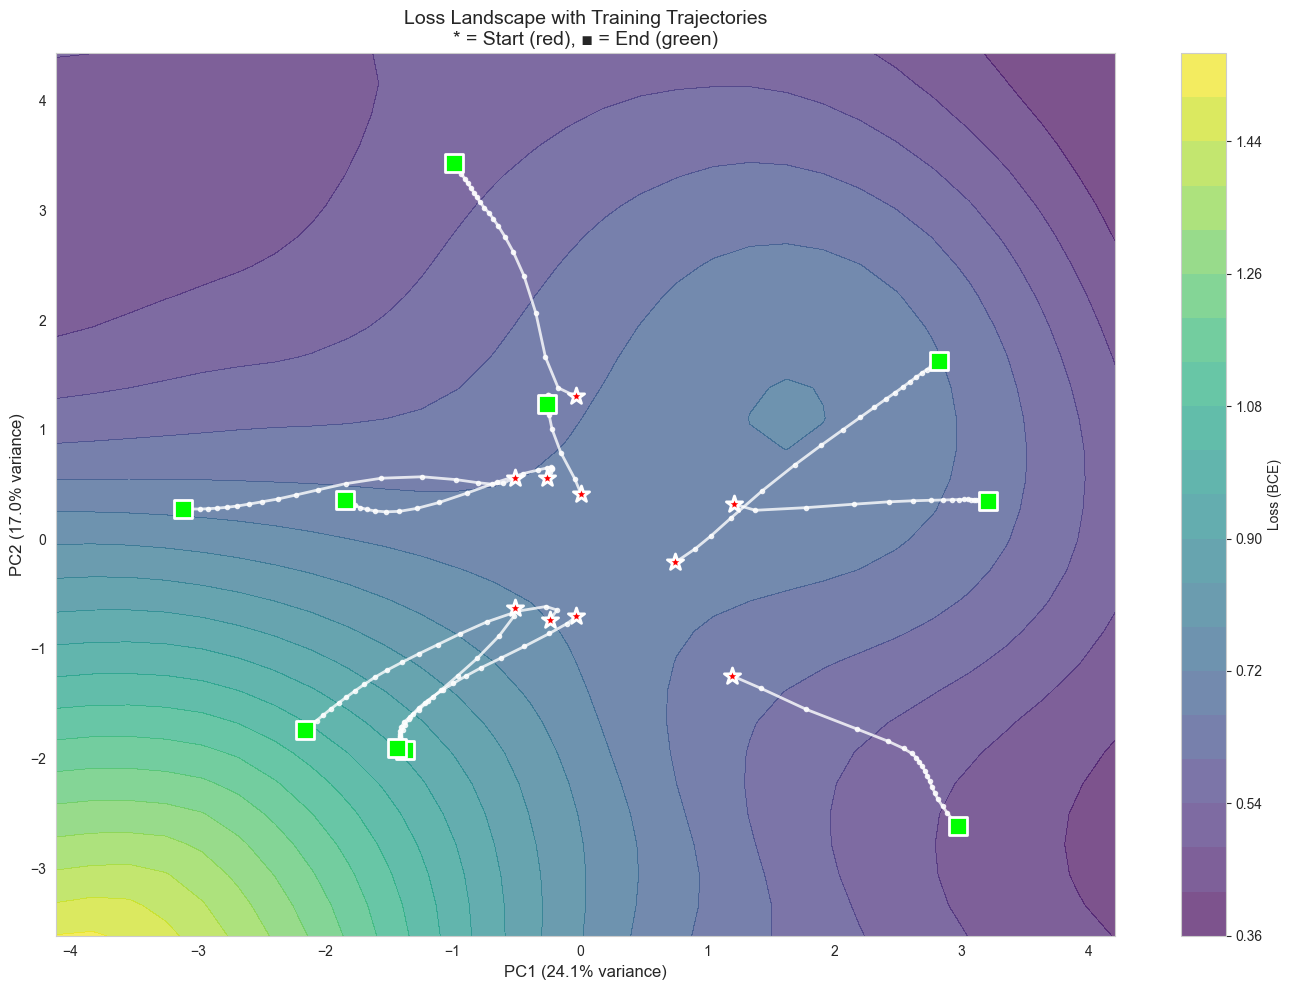

In [10]:
# Visualize the loss landscape with trajectories
plt.figure(figsize=(14, 10))

# Plot loss landscape as contour
contour = plt.contourf(xx, yy, loss_landscape, levels=20, cmap='viridis', alpha=0.7)
plt.colorbar(contour, label='Loss (BCE)')

# Overlay trajectories
for i in range(num_networks):
    mask = trajectory_indices == i
    traj_2d = weights_2d[mask]
    plt.plot(traj_2d[:, 0], traj_2d[:, 1], 'o-', color='white', 
             alpha=0.8, linewidth=2, markersize=3)
    plt.scatter(traj_2d[0, 0], traj_2d[0, 1], color='red', 
                s=150, marker='*', edgecolors='white', linewidths=2, zorder=5)
    plt.scatter(traj_2d[-1, 0], traj_2d[-1, 1], color='lime', 
                s=150, marker='s', edgecolors='white', linewidths=2, zorder=5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Loss Landscape with Training Trajectories\n* = Start (red), ■ = End (green)', fontsize=14)
plt.grid(True, alpha=0.3, color='white')
plt.tight_layout()
plt.show()


## Conclusion

This notebook demonstrated how to visualize loss landscapes by training multiple neural networks with different random initializations on the same dataset. Key observations:

1. Different random initializations lead to different starting points in weight space
2. Despite different trajectories, networks tend to converge to similar loss values
3. The PCA projection reveals that optimization paths can vary significantly even with identical training procedures
4. The loss landscape shows the complex, non-convex nature of neural network optimization
5. All networks successfully navigate from their random starting points to low-loss regions

This visualization technique helps us understand the geometry of neural network optimization and why different initializations can lead to different solutions with similar performance. The loss landscape perspective provides valuable insights into the training dynamics of deep learning models.
